In [1]:
# prompt: connect to google drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install facenet_pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 22.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 35.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 84.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.6/755.6 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 87.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 79.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 44.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 787.5 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from PIL import Image
import numpy as np
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from facenet_pytorch import MTCNN
from torch.utils.data import Dataset, DataLoader, Subset
import cv2
import os


In [ ]:
# prompt: unzip file from google drive

import zipfile

zip_file_path = '/content/drive/MyDrive/Research on BD NYU /development/FER 2013/fer-2013.zip' # Replace with the actual path to your zip file
extract_path = '/content/drive/MyDrive/Research on BD NYU /development/FER 2013' # Replace with the desired extraction path

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
  zip_ref.extractall(extract_path)

print(f"Files extracted to: {extract_path}")


KeyboardInterrupt: 

### 0.0 EDA

In [10]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image
from collections import defaultdict
from sklearn.model_selection import train_test_split

In [11]:
# Define paths (adjust according to your actual paths)
base_path = '/content/drive/MyDrive/Research on BD NYU /development/FER 2013'
train_path = os.path.join(base_path, 'train')
test_path = os.path.join(base_path, 'test')

# List all emotion categories
emotions = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

# Count images in each category
def count_images(path):
    counts = {}
    for emotion in emotions:
        emotion_path = os.path.join(path, emotion)
        counts[emotion] = len(os.listdir(emotion_path))
    return counts

train_counts = count_images(train_path)
test_counts = count_images(test_path)

# Create a DataFrame for visualization
count_df = pd.DataFrame({
    'Emotion': emotions,
    'Train': [train_counts[e] for e in emotions],
    'Test': [test_counts[e] for e in emotions]
})

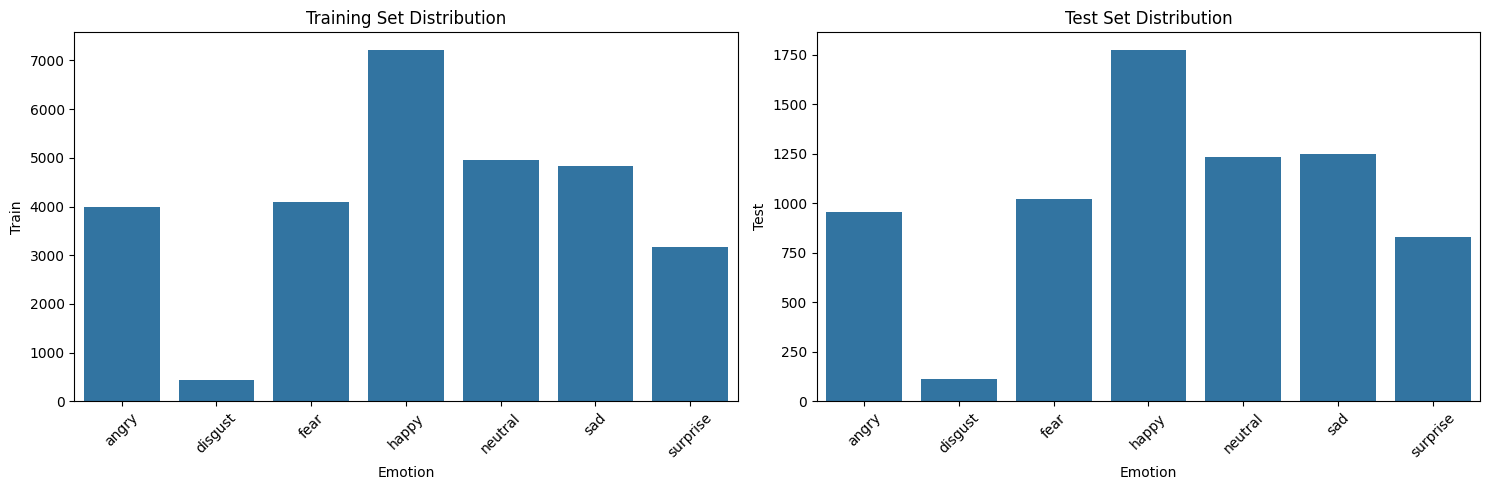

Training Set Counts:
    Emotion  Train
0     angry   3995
1   disgust    436
2      fear   4097
3     happy   7215
4   neutral   4965
5       sad   4830
6  surprise   3171

Test Set Counts:
    Emotion  Test
0     angry   958
1   disgust   111
2      fear  1024
3     happy  1774
4   neutral  1233
5       sad  1247
6  surprise   831


In [12]:
# Plot class distribution
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
sns.barplot(x='Emotion', y='Train', data=count_df)
plt.title('Training Set Distribution')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
sns.barplot(x='Emotion', y='Test', data=count_df)
plt.title('Test Set Distribution')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Print exact counts
print("Training Set Counts:")
print(count_df[['Emotion', 'Train']])
print("\nTest Set Counts:")
print(count_df[['Emotion', 'Test']])

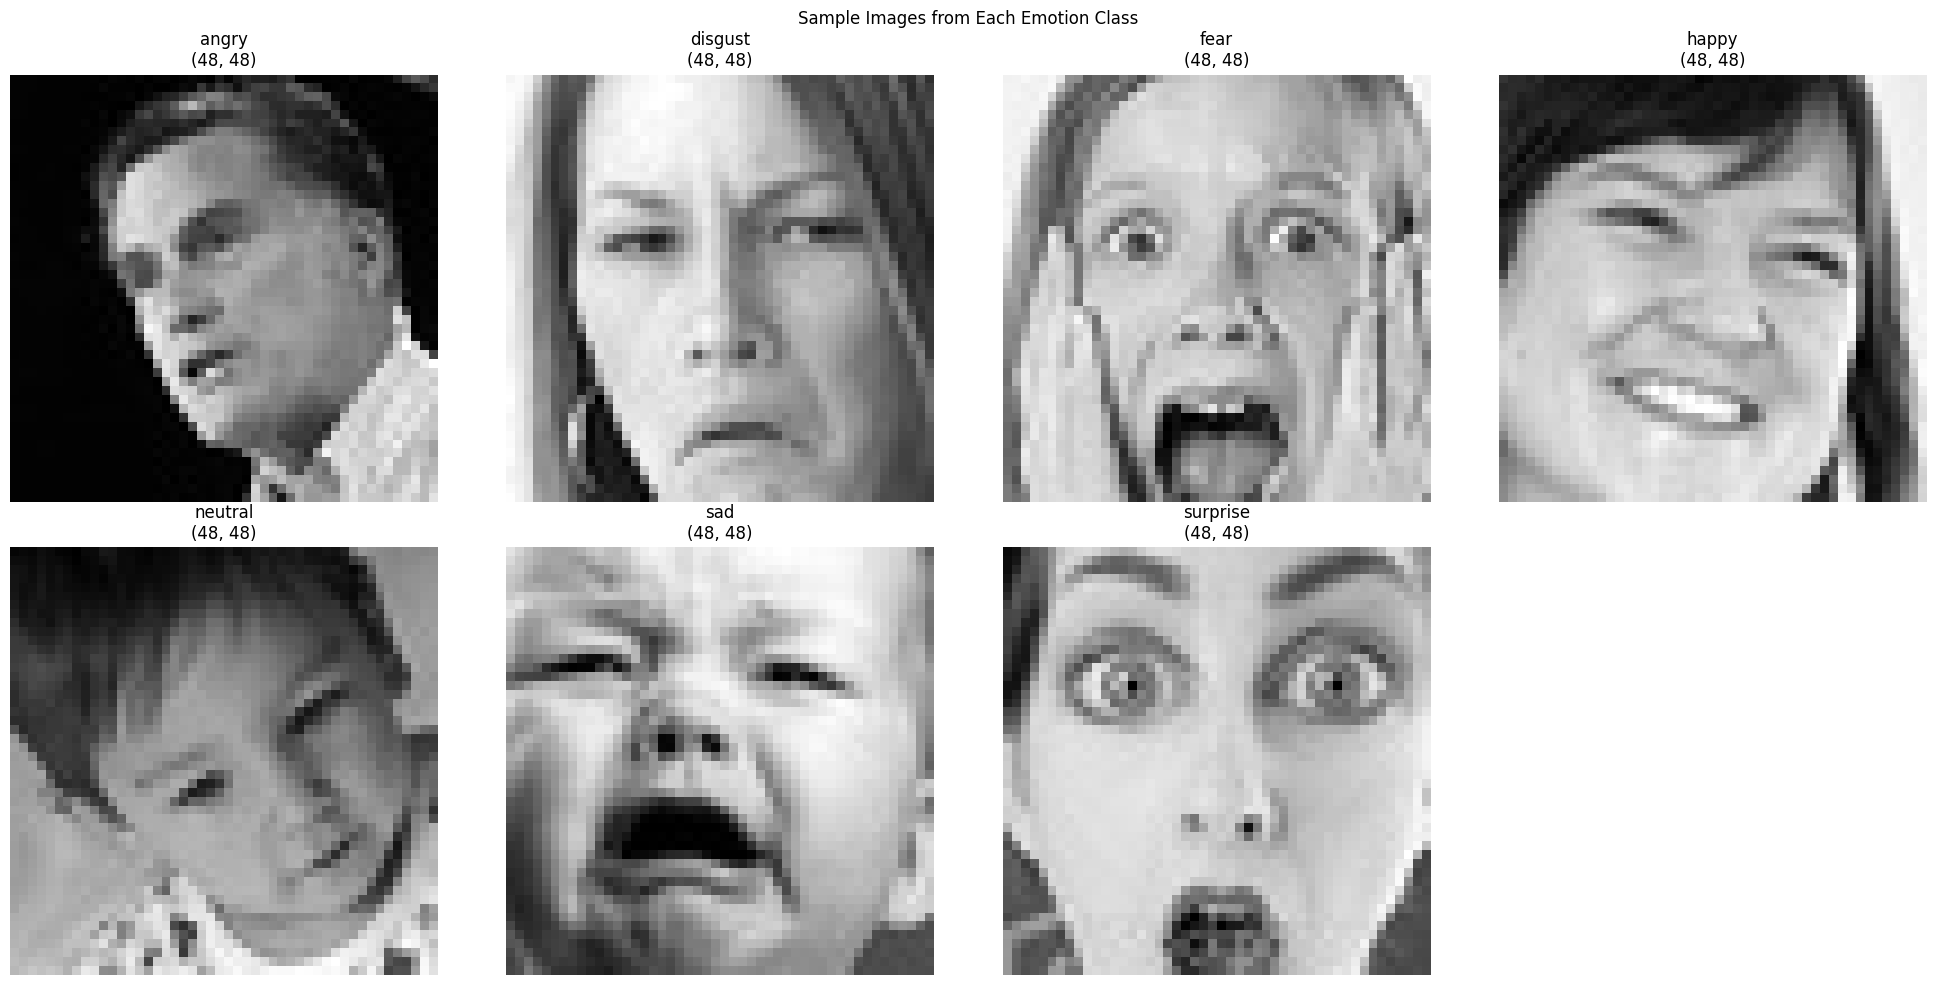

In [13]:
# Display sample images from each class
plt.figure(figsize=(20, 10))
for i, emotion in enumerate(emotions):
    # Get a random image from each emotion folder
    img_path = os.path.join(train_path, emotion)
    img_file = np.random.choice(os.listdir(img_path))
    img = cv2.imread(os.path.join(img_path, img_file))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    plt.subplot(2, 4, i+1)
    plt.imshow(img, cmap='gray')
    plt.title(f'{emotion}\n{img.shape}')
    plt.axis('off')

plt.suptitle('Sample Images from Each Emotion Class', y=0.98)
plt.tight_layout()
plt.show()

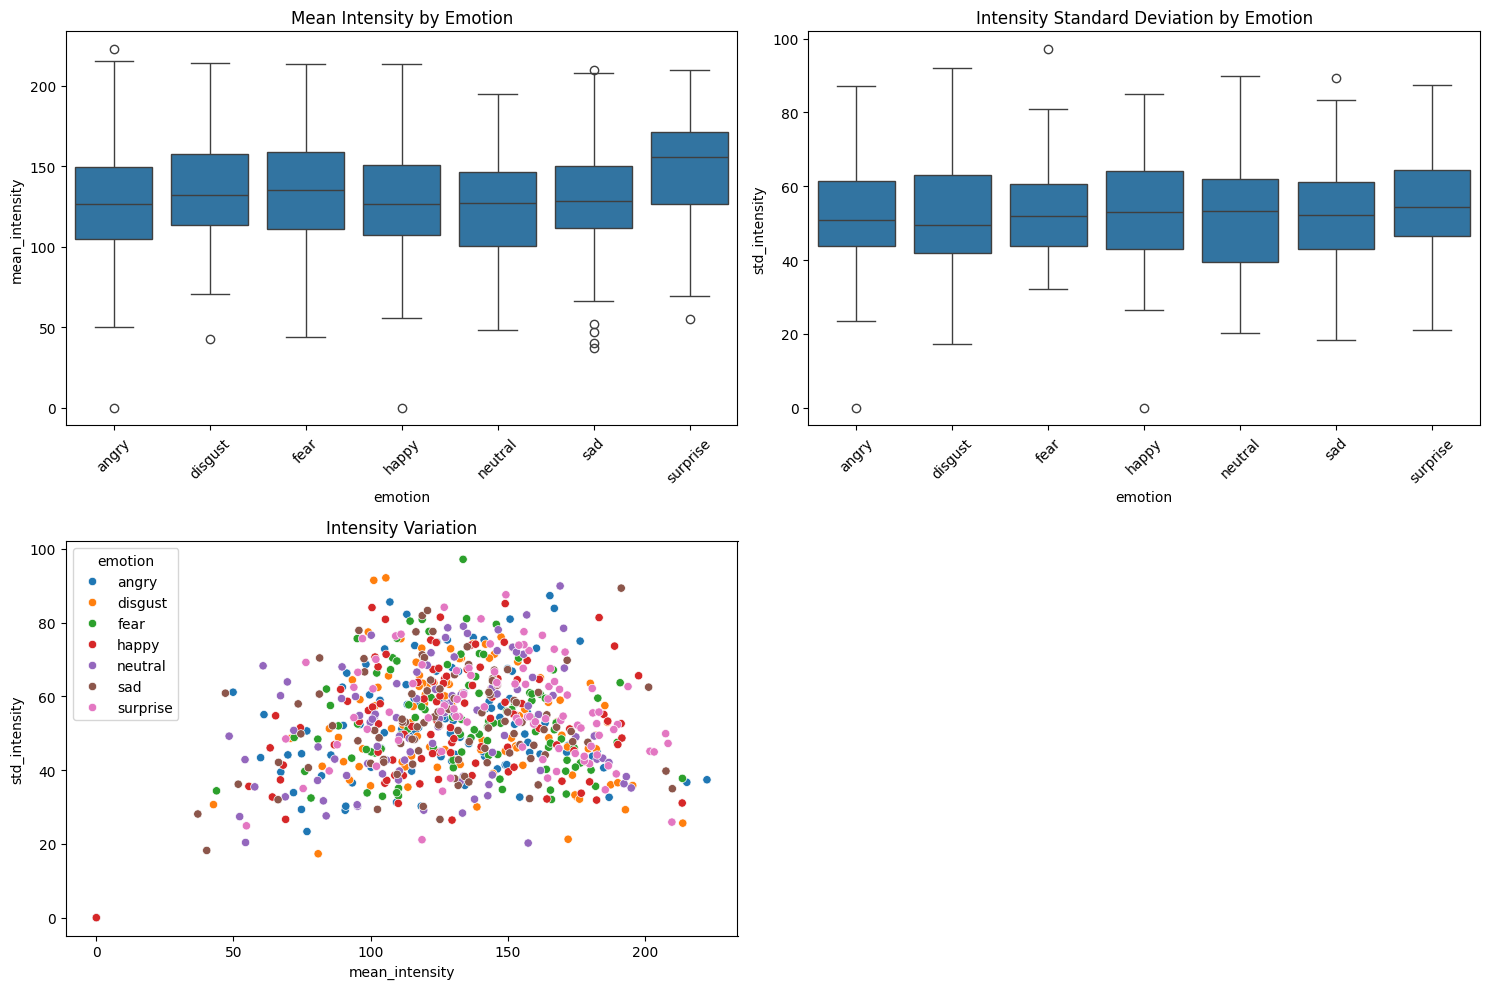

In [14]:
# Analyze image properties
def analyze_image_properties(path):
    properties = defaultdict(list)
    for emotion in emotions:
        emotion_path = os.path.join(path, emotion)
        for img_file in os.listdir(emotion_path)[:100]:  # Sample 100 images per class
            img = cv2.imread(os.path.join(emotion_path, img_file))
            if img is not None:
                properties['emotion'].append(emotion)
                properties['height'].append(img.shape[0])
                properties['width'].append(img.shape[1])
                properties['channels'].append(img.shape[2] if len(img.shape) > 2 else 1)
                properties['mean_intensity'].append(np.mean(img))
                properties['std_intensity'].append(np.std(img))
    return pd.DataFrame(properties)

train_props = analyze_image_properties(train_path)

# Plot properties
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
sns.boxplot(x='emotion', y='mean_intensity', data=train_props)
plt.title('Mean Intensity by Emotion')
plt.xticks(rotation=45)

plt.subplot(2, 2, 2)
sns.boxplot(x='emotion', y='std_intensity', data=train_props)
plt.title('Intensity Standard Deviation by Emotion')
plt.xticks(rotation=45)

plt.subplot(2, 2, 3)
sns.scatterplot(x='mean_intensity', y='std_intensity', hue='emotion', data=train_props)
plt.title('Intensity Variation')

plt.tight_layout()
plt.show()

In [15]:
# Create DataFrame with image paths and labels
def create_image_df(path):
    image_data = []
    for emotion in emotions:
        emotion_path = os.path.join(path, emotion)
        for img_file in os.listdir(emotion_path):
            image_data.append({
                'path': os.path.join(emotion_path, img_file),
                'emotion': emotion,
                'label': emotions.index(emotion)
            })
    return pd.DataFrame(image_data)

train_df = create_image_df(train_path)
test_df = create_image_df(test_path)

# Verify the DataFrame
print(f"Training samples: {len(train_df)}")
print(f"Test samples: {len(test_df)}")
print("\nTraining set distribution:")
print(train_df['emotion'].value_counts())

Training samples: 28709
Test samples: 7178

Training set distribution:
emotion
happy       7215
neutral     4965
sad         4830
fear        4097
angry       3995
surprise    3171
disgust      436
Name: count, dtype: int64


### 1.0 Baseline Model

In [ ]:
# Get image paths and labels from the DataFrames
X_train = train_df['path'].values
y_train = train_df['label'].values
X_test = test_df['path'].values
y_test = test_df['label'].values

In [ ]:
## ----------------------------
## 1. Custom Dataset Class for Your Data
## ----------------------------
import torch

class PathDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]

        try:
            # Load image directly from path
            img = Image.open(img_path).convert('L')  # Convert to grayscale
            if self.transform:
                img = self.transform(img)
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
            # Return zero tensor if image fails to load
            img = torch.zeros(1, 48, 48)  # Adjust size as needed

        label = self.labels[idx]
        # Map original labels to your 3 classes (0, 1, 2)
        # Adjust this mapping based on your specific label correspondence
        if label == 0 or label == 1 or label == 2 or label == 5:  # Example: mapping angry, disgust, fear, and sad to 'depression' (0)
             label = 0
        elif label == 3:  # Example: mapping happy to 'euthymia'(1)
            label = 1
        elif label == 4 or label == 6:  # Example: mapping neutral and surprise to 'mania'(2)
            label = 2
        else:
            # Handle other labels if needed (e.g., skip them or raise an error)
            print(f"Unexpected label: {label}")

        return img, label

In [ ]:
## ----------------------------
## 2. Data Transforms
## ----------------------------

train_transform = transforms.Compose([
    transforms.Resize((48, 48)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

test_transform = transforms.Compose([
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])




In [ ]:
## ----------------------------
## 3. Create Datasets and DataLoaders
## ----------------------------

# Use your existing arrays
train_dataset = PathDataset(X_train, y_train, transform=train_transform)
test_dataset = PathDataset(X_test, y_test, transform=test_transform)

batch_size = 32
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)


In [ ]:
## ----------------------------
## 4. Model Definition (Same as Before)
## ----------------------------

class BipolarCNN(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*12*12, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model = BipolarCNN(num_classes=3)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


In [ ]:
## ----------------------------
## 5. Training Setup
## ----------------------------

# Calculate class weights from your y_train, but only for the 3 relevant classes
# Filter y_train to include only labels 0, 1, 2 (your 3 classes)
filtered_y_train = torch.from_numpy(y_train[np.isin(y_train, [0, 1, 2])])

# Calculate class weights using the filtered labels
class_counts = torch.bincount(filtered_y_train)
class_weights = 1. / class_counts.float()
class_weights = class_weights / class_weights.sum()

criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))  # Apply weights to the loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3)



In [ ]:
## ----------------------------
## 6. Training Loop (Same as Before)
## ----------------------------

num_epochs = 50
best_acc = 0.0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        pbar.set_postfix({
            'loss': running_loss/(pbar.n+1),
            'acc': 100.*correct/total
        })

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            val_loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_acc = 100.*val_correct/val_total
    scheduler.step(val_loss)

    print(f"Val Loss: {val_loss/len(test_loader):.4f}, Val Acc: {val_acc:.2f}%")

    # Save best model
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pth')



Epoch 1/50:  81%|████████  | 726/898 [08:00<02:53,  1.01s/it, loss=0.756, acc=25.3]

Error loading /content/drive/MyDrive/Research on BD NYU /development/FER 2013/train/sad/Training_3749125.jpg: cannot identify image file '/content/drive/MyDrive/Research on BD NYU /development/FER 2013/train/sad/Training_3749125.jpg'


Epoch 1/50: 100%|██████████| 898/898 [09:52<00:00,  1.52it/s, loss=0.735, acc=25.4]


Val Loss: 1.3514, Val Acc: 24.71%


Epoch 2/50:  24%|██▍       | 216/898 [01:05<02:53,  3.93it/s, loss=0.65, acc=25.2]

Error loading /content/drive/MyDrive/Research on BD NYU /development/FER 2013/train/sad/Training_3749125.jpg: cannot identify image file '/content/drive/MyDrive/Research on BD NYU /development/FER 2013/train/sad/Training_3749125.jpg'


Epoch 2/50: 100%|██████████| 898/898 [04:31<00:00,  3.30it/s, loss=0.632, acc=25.1]


Val Loss: 1.2234, Val Acc: 24.71%


Epoch 3/50:  42%|████▏     | 379/898 [01:59<03:33,  2.43it/s, loss=0.624, acc=24.8]

Error loading /content/drive/MyDrive/Research on BD NYU /development/FER 2013/train/sad/Training_3749125.jpg: cannot identify image file '/content/drive/MyDrive/Research on BD NYU /development/FER 2013/train/sad/Training_3749125.jpg'


Epoch 3/50: 100%|██████████| 898/898 [04:35<00:00,  3.26it/s, loss=0.604, acc=25.1]


Val Loss: 1.1717, Val Acc: 24.71%


Epoch 4/50:  96%|█████████▌| 860/898 [04:22<00:12,  3.07it/s, loss=0.59, acc=25.1]

Error loading /content/drive/MyDrive/Research on BD NYU /development/FER 2013/train/sad/Training_3749125.jpg: cannot identify image file '/content/drive/MyDrive/Research on BD NYU /development/FER 2013/train/sad/Training_3749125.jpg'


Epoch 4/50: 100%|██████████| 898/898 [04:34<00:00,  3.27it/s, loss=0.588, acc=25.1]


Val Loss: 1.2419, Val Acc: 24.71%


Epoch 5/50:  78%|███████▊  | 698/898 [03:32<00:55,  3.59it/s, loss=0.588, acc=25]

Error loading /content/drive/MyDrive/Research on BD NYU /development/FER 2013/train/sad/Training_3749125.jpg: cannot identify image file '/content/drive/MyDrive/Research on BD NYU /development/FER 2013/train/sad/Training_3749125.jpg'


Epoch 5/50: 100%|██████████| 898/898 [04:31<00:00,  3.30it/s, loss=0.583, acc=25.1]


Val Loss: 1.2708, Val Acc: 24.71%


Epoch 6/50:  38%|███▊      | 340/898 [01:43<02:40,  3.49it/s, loss=0.566, acc=25]

Error loading /content/drive/MyDrive/Research on BD NYU /development/FER 2013/train/sad/Training_3749125.jpg: cannot identify image file '/content/drive/MyDrive/Research on BD NYU /development/FER 2013/train/sad/Training_3749125.jpg'


Epoch 6/50: 100%|██████████| 898/898 [04:27<00:00,  3.36it/s, loss=0.569, acc=25.1]


Val Loss: 1.1268, Val Acc: 24.71%


Epoch 7/50:  29%|██▉       | 261/898 [01:22<04:14,  2.50it/s, loss=0.559, acc=25.2]

Error loading /content/drive/MyDrive/Research on BD NYU /development/FER 2013/train/sad/Training_3749125.jpg: cannot identify image file '/content/drive/MyDrive/Research on BD NYU /development/FER 2013/train/sad/Training_3749125.jpg'


Epoch 7/50: 100%|██████████| 898/898 [04:35<00:00,  3.26it/s, loss=0.56, acc=30.4]


Val Loss: 1.2522, Val Acc: 38.09%


Epoch 8/50:  86%|████████▌ | 772/898 [03:51<00:31,  4.04it/s, loss=0.556, acc=46.2]

Error loading /content/drive/MyDrive/Research on BD NYU /development/FER 2013/train/sad/Training_3749125.jpg: cannot identify image file '/content/drive/MyDrive/Research on BD NYU /development/FER 2013/train/sad/Training_3749125.jpg'


Epoch 8/50: 100%|██████████| 898/898 [04:27<00:00,  3.36it/s, loss=0.555, acc=46.4]


Val Loss: 1.1010, Val Acc: 49.51%


Epoch 9/50:  58%|█████▊    | 523/898 [02:28<01:29,  4.18it/s, loss=0.548, acc=48.1]

Error loading /content/drive/MyDrive/Research on BD NYU /development/FER 2013/train/sad/Training_3749125.jpg: cannot identify image file '/content/drive/MyDrive/Research on BD NYU /development/FER 2013/train/sad/Training_3749125.jpg'


Epoch 9/50: 100%|██████████| 898/898 [04:14<00:00,  3.53it/s, loss=0.543, acc=48.5]


Val Loss: 1.2027, Val Acc: 45.86%


Epoch 10/50:  79%|███████▊  | 707/898 [03:22<01:13,  2.60it/s, loss=0.54, acc=49.9]

Error loading /content/drive/MyDrive/Research on BD NYU /development/FER 2013/train/sad/Training_3749125.jpg: cannot identify image file '/content/drive/MyDrive/Research on BD NYU /development/FER 2013/train/sad/Training_3749125.jpg'


Epoch 10/50: 100%|██████████| 898/898 [04:16<00:00,  3.51it/s, loss=0.541, acc=49.9]


Val Loss: 1.0486, Val Acc: 51.49%


Epoch 11/50:  19%|█▉        | 170/898 [00:52<04:47,  2.53it/s, loss=0.547, acc=49.7]

Error loading /content/drive/MyDrive/Research on BD NYU /development/FER 2013/train/sad/Training_3749125.jpg: cannot identify image file '/content/drive/MyDrive/Research on BD NYU /development/FER 2013/train/sad/Training_3749125.jpg'


Epoch 11/50: 100%|██████████| 898/898 [04:14<00:00,  3.53it/s, loss=0.528, acc=50.9]


Val Loss: 1.0546, Val Acc: 54.22%


Epoch 12/50:  83%|████████▎ | 744/898 [03:27<00:37,  4.10it/s, loss=0.524, acc=51.6]

Error loading /content/drive/MyDrive/Research on BD NYU /development/FER 2013/train/sad/Training_3749125.jpg: cannot identify image file '/content/drive/MyDrive/Research on BD NYU /development/FER 2013/train/sad/Training_3749125.jpg'


Epoch 12/50: 100%|██████████| 898/898 [04:11<00:00,  3.58it/s, loss=0.527, acc=51.4]


Val Loss: 1.0171, Val Acc: 54.11%


Epoch 13/50:  56%|█████▌    | 501/898 [02:18<02:21,  2.82it/s, loss=0.533, acc=51.5]

Error loading /content/drive/MyDrive/Research on BD NYU /development/FER 2013/train/sad/Training_3749125.jpg: cannot identify image file '/content/drive/MyDrive/Research on BD NYU /development/FER 2013/train/sad/Training_3749125.jpg'


Epoch 13/50: 100%|██████████| 898/898 [04:08<00:00,  3.61it/s, loss=0.526, acc=51.8]


Val Loss: 1.0478, Val Acc: 51.06%


Epoch 14/50:  60%|██████    | 541/898 [02:30<01:22,  4.33it/s, loss=0.514, acc=52.5]

Error loading /content/drive/MyDrive/Research on BD NYU /development/FER 2013/train/sad/Training_3749125.jpg: cannot identify image file '/content/drive/MyDrive/Research on BD NYU /development/FER 2013/train/sad/Training_3749125.jpg'


Epoch 14/50: 100%|██████████| 898/898 [04:10<00:00,  3.59it/s, loss=0.519, acc=52.6]


Val Loss: 1.0062, Val Acc: 54.24%


Epoch 15/50:  50%|████▉     | 448/898 [02:03<01:46,  4.23it/s, loss=0.509, acc=52.8]

Error loading /content/drive/MyDrive/Research on BD NYU /development/FER 2013/train/sad/Training_3749125.jpg: cannot identify image file '/content/drive/MyDrive/Research on BD NYU /development/FER 2013/train/sad/Training_3749125.jpg'


Epoch 15/50: 100%|██████████| 898/898 [04:07<00:00,  3.63it/s, loss=0.509, acc=53.2]


Val Loss: 1.0121, Val Acc: 55.93%


Epoch 16/50:  13%|█▎        | 121/898 [00:35<03:40,  3.52it/s, loss=0.504, acc=55.1]

Error loading /content/drive/MyDrive/Research on BD NYU /development/FER 2013/train/sad/Training_3749125.jpg: cannot identify image file '/content/drive/MyDrive/Research on BD NYU /development/FER 2013/train/sad/Training_3749125.jpg'


Epoch 16/50: 100%|██████████| 898/898 [04:07<00:00,  3.63it/s, loss=0.508, acc=54.2]


Val Loss: 1.1750, Val Acc: 49.40%


Epoch 17/50:  88%|████████▊ | 792/898 [03:39<00:40,  2.60it/s, loss=0.501, acc=54.2]

Error loading /content/drive/MyDrive/Research on BD NYU /development/FER 2013/train/sad/Training_3749125.jpg: cannot identify image file '/content/drive/MyDrive/Research on BD NYU /development/FER 2013/train/sad/Training_3749125.jpg'


Epoch 17/50: 100%|██████████| 898/898 [04:08<00:00,  3.61it/s, loss=0.502, acc=54.3]


Val Loss: 1.0294, Val Acc: 55.98%


Epoch 18/50:  13%|█▎        | 115/898 [00:31<03:07,  4.18it/s, loss=0.512, acc=55]

Error loading /content/drive/MyDrive/Research on BD NYU /development/FER 2013/train/sad/Training_3749125.jpg: cannot identify image file '/content/drive/MyDrive/Research on BD NYU /development/FER 2013/train/sad/Training_3749125.jpg'


Epoch 18/50: 100%|██████████| 898/898 [04:03<00:00,  3.69it/s, loss=0.502, acc=54.5]


Val Loss: 1.0159, Val Acc: 55.68%


Epoch 19/50:  45%|████▌     | 405/898 [01:53<02:02,  4.03it/s, loss=0.494, acc=55.7]

Error loading /content/drive/MyDrive/Research on BD NYU /development/FER 2013/train/sad/Training_3749125.jpg: cannot identify image file '/content/drive/MyDrive/Research on BD NYU /development/FER 2013/train/sad/Training_3749125.jpg'


Epoch 19/50: 100%|██████████| 898/898 [04:06<00:00,  3.65it/s, loss=0.485, acc=56.4]


Val Loss: 0.9891, Val Acc: 57.19%


Epoch 20/50:  10%|▉         | 89/898 [00:25<03:15,  4.14it/s, loss=0.486, acc=56.7]

Error loading /content/drive/MyDrive/Research on BD NYU /development/FER 2013/train/sad/Training_3749125.jpg: cannot identify image file '/content/drive/MyDrive/Research on BD NYU /development/FER 2013/train/sad/Training_3749125.jpg'


Epoch 20/50: 100%|██████████| 898/898 [04:05<00:00,  3.66it/s, loss=0.48, acc=56.7]


Val Loss: 0.9795, Val Acc: 57.93%


Epoch 21/50:  24%|██▍       | 217/898 [01:01<02:43,  4.18it/s, loss=0.469, acc=58.1]

Error loading /content/drive/MyDrive/Research on BD NYU /development/FER 2013/train/sad/Training_3749125.jpg: cannot identify image file '/content/drive/MyDrive/Research on BD NYU /development/FER 2013/train/sad/Training_3749125.jpg'


Epoch 21/50: 100%|██████████| 898/898 [04:04<00:00,  3.67it/s, loss=0.47, acc=57.4]


Val Loss: 0.9640, Val Acc: 58.09%


Epoch 22/50:  82%|████████▏ | 739/898 [03:23<00:37,  4.25it/s, loss=0.474, acc=57.5]

Error loading /content/drive/MyDrive/Research on BD NYU /development/FER 2013/train/sad/Training_3749125.jpg: cannot identify image file '/content/drive/MyDrive/Research on BD NYU /development/FER 2013/train/sad/Training_3749125.jpg'


Epoch 22/50: 100%|██████████| 898/898 [04:05<00:00,  3.66it/s, loss=0.471, acc=57.6]


Val Loss: 0.9987, Val Acc: 56.37%


Epoch 23/50:  42%|████▏     | 374/898 [01:44<02:05,  4.16it/s, loss=0.456, acc=57.9]

Error loading /content/drive/MyDrive/Research on BD NYU /development/FER 2013/train/sad/Training_3749125.jpg: cannot identify image file '/content/drive/MyDrive/Research on BD NYU /development/FER 2013/train/sad/Training_3749125.jpg'


Epoch 23/50: 100%|██████████| 898/898 [04:05<00:00,  3.66it/s, loss=0.463, acc=57.7]


Val Loss: 0.9783, Val Acc: 56.91%


Epoch 24/50:  21%|██        | 189/898 [00:52<02:52,  4.11it/s, loss=0.458, acc=57.9]

Error loading /content/drive/MyDrive/Research on BD NYU /development/FER 2013/train/sad/Training_3749125.jpg: cannot identify image file '/content/drive/MyDrive/Research on BD NYU /development/FER 2013/train/sad/Training_3749125.jpg'


Epoch 24/50: 100%|██████████| 898/898 [04:03<00:00,  3.69it/s, loss=0.46, acc=58.1]


Val Loss: 0.9632, Val Acc: 57.69%


Epoch 25/50:  50%|████▉     | 446/898 [02:00<02:41,  2.80it/s, loss=0.459, acc=58.5]

Error loading /content/drive/MyDrive/Research on BD NYU /development/FER 2013/train/sad/Training_3749125.jpg: cannot identify image file '/content/drive/MyDrive/Research on BD NYU /development/FER 2013/train/sad/Training_3749125.jpg'


Epoch 25/50: 100%|██████████| 898/898 [04:02<00:00,  3.71it/s, loss=0.457, acc=58.7]


Val Loss: 0.9545, Val Acc: 57.86%


Epoch 26/50:  69%|██████▊   | 616/898 [02:47<01:49,  2.57it/s, loss=0.457, acc=58.7]

Error loading /content/drive/MyDrive/Research on BD NYU /development/FER 2013/train/sad/Training_3749125.jpg: cannot identify image file '/content/drive/MyDrive/Research on BD NYU /development/FER 2013/train/sad/Training_3749125.jpg'


Epoch 26/50: 100%|██████████| 898/898 [04:02<00:00,  3.71it/s, loss=0.457, acc=58.9]


Val Loss: 0.9248, Val Acc: 58.40%


Epoch 27/50:  44%|████▍     | 394/898 [01:46<01:59,  4.22it/s, loss=0.454, acc=59.7]

Error loading /content/drive/MyDrive/Research on BD NYU /development/FER 2013/train/sad/Training_3749125.jpg: cannot identify image file '/content/drive/MyDrive/Research on BD NYU /development/FER 2013/train/sad/Training_3749125.jpg'


Epoch 27/50: 100%|██████████| 898/898 [04:02<00:00,  3.70it/s, loss=0.456, acc=59.7]


Val Loss: 0.9402, Val Acc: 59.47%


Epoch 28/50:  44%|████▍     | 397/898 [01:48<02:02,  4.08it/s, loss=0.464, acc=59.3]

Error loading /content/drive/MyDrive/Research on BD NYU /development/FER 2013/train/sad/Training_3749125.jpg: cannot identify image file '/content/drive/MyDrive/Research on BD NYU /development/FER 2013/train/sad/Training_3749125.jpg'


Epoch 28/50: 100%|██████████| 898/898 [04:03<00:00,  3.69it/s, loss=0.457, acc=59.4]


Val Loss: 0.9362, Val Acc: 58.80%


Epoch 29/50:  69%|██████▉   | 618/898 [02:47<01:07,  4.15it/s, loss=0.457, acc=59.5]

Error loading /content/drive/MyDrive/Research on BD NYU /development/FER 2013/train/sad/Training_3749125.jpg: cannot identify image file '/content/drive/MyDrive/Research on BD NYU /development/FER 2013/train/sad/Training_3749125.jpg'


Epoch 29/50: 100%|██████████| 898/898 [04:04<00:00,  3.67it/s, loss=0.452, acc=60.1]


Val Loss: 0.9335, Val Acc: 59.74%


Epoch 30/50:  30%|███       | 270/898 [01:13<02:23,  4.39it/s, loss=0.449, acc=59.7]

Error loading /content/drive/MyDrive/Research on BD NYU /development/FER 2013/train/sad/Training_3749125.jpg: cannot identify image file '/content/drive/MyDrive/Research on BD NYU /development/FER 2013/train/sad/Training_3749125.jpg'


Epoch 30/50: 100%|██████████| 898/898 [04:04<00:00,  3.67it/s, loss=0.451, acc=59.9]


Val Loss: 0.9592, Val Acc: 58.80%


Epoch 31/50:  41%|████      | 367/898 [01:39<02:07,  4.15it/s, loss=0.44, acc=60]

Error loading /content/drive/MyDrive/Research on BD NYU /development/FER 2013/train/sad/Training_3749125.jpg: cannot identify image file '/content/drive/MyDrive/Research on BD NYU /development/FER 2013/train/sad/Training_3749125.jpg'


Epoch 31/50: 100%|██████████| 898/898 [04:05<00:00,  3.66it/s, loss=0.445, acc=60.1]


Val Loss: 0.9280, Val Acc: 59.52%


Epoch 32/50:  90%|████████▉ | 808/898 [03:41<00:32,  2.79it/s, loss=0.444, acc=60.4]

Error loading /content/drive/MyDrive/Research on BD NYU /development/FER 2013/train/sad/Training_3749125.jpg: cannot identify image file '/content/drive/MyDrive/Research on BD NYU /development/FER 2013/train/sad/Training_3749125.jpg'


Epoch 32/50: 100%|██████████| 898/898 [04:05<00:00,  3.66it/s, loss=0.446, acc=60.2]


Val Loss: 0.9293, Val Acc: 59.72%


Epoch 33/50:  38%|███▊      | 344/898 [01:33<02:12,  4.17it/s, loss=0.443, acc=60.9]

Error loading /content/drive/MyDrive/Research on BD NYU /development/FER 2013/train/sad/Training_3749125.jpg: cannot identify image file '/content/drive/MyDrive/Research on BD NYU /development/FER 2013/train/sad/Training_3749125.jpg'


Epoch 33/50: 100%|██████████| 898/898 [04:04<00:00,  3.68it/s, loss=0.443, acc=60.6]


Val Loss: 0.9262, Val Acc: 60.17%


Epoch 34/50:  66%|██████▌   | 591/898 [02:38<01:54,  2.68it/s, loss=0.445, acc=60.8]

Error loading /content/drive/MyDrive/Research on BD NYU /development/FER 2013/train/sad/Training_3749125.jpg: cannot identify image file '/content/drive/MyDrive/Research on BD NYU /development/FER 2013/train/sad/Training_3749125.jpg'


Epoch 34/50: 100%|██████████| 898/898 [04:01<00:00,  3.73it/s, loss=0.446, acc=60.5]


Val Loss: 0.9313, Val Acc: 60.10%


Epoch 35/50:  16%|█▌        | 142/898 [00:35<02:45,  4.56it/s, loss=0.438, acc=61.6]

Error loading /content/drive/MyDrive/Research on BD NYU /development/FER 2013/train/sad/Training_3749125.jpg: cannot identify image file '/content/drive/MyDrive/Research on BD NYU /development/FER 2013/train/sad/Training_3749125.jpg'


Epoch 35/50: 100%|██████████| 898/898 [03:56<00:00,  3.80it/s, loss=0.443, acc=60.7]


Val Loss: 0.9375, Val Acc: 59.92%


Epoch 36/50:  68%|██████▊   | 612/898 [02:43<01:05,  4.39it/s, loss=0.45, acc=60.1]

Error loading /content/drive/MyDrive/Research on BD NYU /development/FER 2013/train/sad/Training_3749125.jpg: cannot identify image file '/content/drive/MyDrive/Research on BD NYU /development/FER 2013/train/sad/Training_3749125.jpg'


Epoch 36/50: 100%|██████████| 898/898 [04:02<00:00,  3.70it/s, loss=0.446, acc=60.4]


Val Loss: 0.9212, Val Acc: 60.39%


Epoch 37/50:  14%|█▍        | 130/898 [00:34<03:19,  3.85it/s, loss=0.449, acc=60.3]

Error loading /content/drive/MyDrive/Research on BD NYU /development/FER 2013/train/sad/Training_3749125.jpg: cannot identify image file '/content/drive/MyDrive/Research on BD NYU /development/FER 2013/train/sad/Training_3749125.jpg'


Epoch 37/50: 100%|██████████| 898/898 [04:04<00:00,  3.68it/s, loss=0.445, acc=60.4]


Val Loss: 0.9255, Val Acc: 60.06%


Epoch 38/50:  86%|████████▌ | 769/898 [03:25<00:30,  4.22it/s, loss=0.449, acc=60]

Error loading /content/drive/MyDrive/Research on BD NYU /development/FER 2013/train/sad/Training_3749125.jpg: cannot identify image file '/content/drive/MyDrive/Research on BD NYU /development/FER 2013/train/sad/Training_3749125.jpg'


Epoch 38/50: 100%|██████████| 898/898 [03:59<00:00,  3.74it/s, loss=0.447, acc=60.3]


Val Loss: 0.9305, Val Acc: 60.14%


Epoch 39/50:  45%|████▌     | 406/898 [01:49<02:50,  2.89it/s, loss=0.444, acc=60.9]

Error loading /content/drive/MyDrive/Research on BD NYU /development/FER 2013/train/sad/Training_3749125.jpg: cannot identify image file '/content/drive/MyDrive/Research on BD NYU /development/FER 2013/train/sad/Training_3749125.jpg'


Epoch 39/50: 100%|██████████| 898/898 [04:04<00:00,  3.67it/s, loss=0.447, acc=60.5]


Val Loss: 0.9273, Val Acc: 60.14%


Epoch 40/50:  11%|█         | 95/898 [00:26<03:10,  4.21it/s, loss=0.429, acc=60.8]

Error loading /content/drive/MyDrive/Research on BD NYU /development/FER 2013/train/sad/Training_3749125.jpg: cannot identify image file '/content/drive/MyDrive/Research on BD NYU /development/FER 2013/train/sad/Training_3749125.jpg'


Epoch 40/50: 100%|██████████| 898/898 [04:02<00:00,  3.71it/s, loss=0.445, acc=60]


Val Loss: 0.9282, Val Acc: 60.39%


Epoch 41/50:  30%|███       | 271/898 [01:14<02:27,  4.24it/s, loss=0.447, acc=60]

Error loading /content/drive/MyDrive/Research on BD NYU /development/FER 2013/train/sad/Training_3749125.jpg: cannot identify image file '/content/drive/MyDrive/Research on BD NYU /development/FER 2013/train/sad/Training_3749125.jpg'


Epoch 41/50: 100%|██████████| 898/898 [04:04<00:00,  3.67it/s, loss=0.445, acc=60.2]


Val Loss: 0.9285, Val Acc: 60.20%


Epoch 42/50:  38%|███▊      | 341/898 [01:31<02:14,  4.14it/s, loss=0.448, acc=60.3]

Error loading /content/drive/MyDrive/Research on BD NYU /development/FER 2013/train/sad/Training_3749125.jpg: cannot identify image file '/content/drive/MyDrive/Research on BD NYU /development/FER 2013/train/sad/Training_3749125.jpg'


Epoch 42/50: 100%|██████████| 898/898 [04:02<00:00,  3.71it/s, loss=0.441, acc=60.4]


Val Loss: 0.9264, Val Acc: 60.18%


Epoch 43/50:  59%|█████▉    | 534/898 [02:25<01:52,  3.23it/s, loss=0.44, acc=61]

Error loading /content/drive/MyDrive/Research on BD NYU /development/FER 2013/train/sad/Training_3749125.jpg: cannot identify image file '/content/drive/MyDrive/Research on BD NYU /development/FER 2013/train/sad/Training_3749125.jpg'


Epoch 43/50: 100%|██████████| 898/898 [04:04<00:00,  3.67it/s, loss=0.443, acc=60.7]


Val Loss: 0.9285, Val Acc: 60.17%


Epoch 44/50:  68%|██████▊   | 615/898 [02:47<01:28,  3.21it/s, loss=0.444, acc=60.6]

Error loading /content/drive/MyDrive/Research on BD NYU /development/FER 2013/train/sad/Training_3749125.jpg: cannot identify image file '/content/drive/MyDrive/Research on BD NYU /development/FER 2013/train/sad/Training_3749125.jpg'


Epoch 44/50: 100%|██████████| 898/898 [04:04<00:00,  3.67it/s, loss=0.443, acc=60.6]


Val Loss: 0.9168, Val Acc: 60.62%


Epoch 45/50:  10%|█         | 93/898 [00:25<03:51,  3.47it/s, loss=0.447, acc=60.8]

Error loading /content/drive/MyDrive/Research on BD NYU /development/FER 2013/train/sad/Training_3749125.jpg: cannot identify image file '/content/drive/MyDrive/Research on BD NYU /development/FER 2013/train/sad/Training_3749125.jpg'


Epoch 45/50: 100%|██████████| 898/898 [04:02<00:00,  3.70it/s, loss=0.445, acc=60.2]


Val Loss: 0.9307, Val Acc: 60.24%


Epoch 46/50:  52%|█████▏    | 464/898 [02:09<01:46,  4.07it/s, loss=0.448, acc=60.2]

Error loading /content/drive/MyDrive/Research on BD NYU /development/FER 2013/train/sad/Training_3749125.jpg: cannot identify image file '/content/drive/MyDrive/Research on BD NYU /development/FER 2013/train/sad/Training_3749125.jpg'


Epoch 46/50: 100%|██████████| 898/898 [04:07<00:00,  3.64it/s, loss=0.444, acc=60.4]


Val Loss: 0.9280, Val Acc: 59.96%


Epoch 47/50:  66%|██████▌   | 591/898 [02:43<01:14,  4.13it/s, loss=0.444, acc=60.2]

Error loading /content/drive/MyDrive/Research on BD NYU /development/FER 2013/train/sad/Training_3749125.jpg: cannot identify image file '/content/drive/MyDrive/Research on BD NYU /development/FER 2013/train/sad/Training_3749125.jpg'


Epoch 47/50: 100%|██████████| 898/898 [04:07<00:00,  3.63it/s, loss=0.442, acc=60.5]


Val Loss: 0.9261, Val Acc: 59.91%


Epoch 48/50:  16%|█▌        | 145/898 [00:40<02:58,  4.22it/s, loss=0.442, acc=60.2]

Error loading /content/drive/MyDrive/Research on BD NYU /development/FER 2013/train/sad/Training_3749125.jpg: cannot identify image file '/content/drive/MyDrive/Research on BD NYU /development/FER 2013/train/sad/Training_3749125.jpg'


Epoch 48/50: 100%|██████████| 898/898 [04:06<00:00,  3.64it/s, loss=0.448, acc=60.3]


Val Loss: 0.9263, Val Acc: 60.02%


Epoch 49/50:  81%|████████  | 726/898 [03:19<00:41,  4.14it/s, loss=0.442, acc=60.6]

Error loading /content/drive/MyDrive/Research on BD NYU /development/FER 2013/train/sad/Training_3749125.jpg: cannot identify image file '/content/drive/MyDrive/Research on BD NYU /development/FER 2013/train/sad/Training_3749125.jpg'


Epoch 49/50: 100%|██████████| 898/898 [04:07<00:00,  3.63it/s, loss=0.445, acc=60.6]


Val Loss: 0.9232, Val Acc: 60.35%


Epoch 50/50:  38%|███▊      | 342/898 [01:36<03:39,  2.53it/s, loss=0.45, acc=60.7]

Error loading /content/drive/MyDrive/Research on BD NYU /development/FER 2013/train/sad/Training_3749125.jpg: cannot identify image file '/content/drive/MyDrive/Research on BD NYU /development/FER 2013/train/sad/Training_3749125.jpg'


Epoch 50/50: 100%|██████████| 898/898 [04:07<00:00,  3.63it/s, loss=0.443, acc=60.6]


Val Loss: 0.9369, Val Acc: 59.81%



Classification Report:
              precision    recall  f1-score   support

  depression       0.62      0.75      0.68      3340
    euthymia       0.56      0.93      0.70      1774
       mania       0.78      0.11      0.19      2064

    accuracy                           0.61      7178
   macro avg       0.66      0.59      0.52      7178
weighted avg       0.66      0.61      0.54      7178



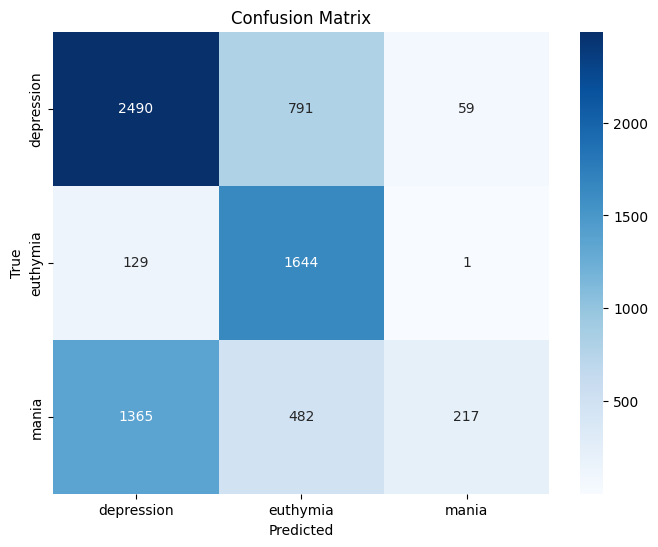

In [ ]:
## ----------------------------
## 7. Evaluation
## ----------------------------

# Load best model
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# Classification report
from sklearn.metrics import classification_report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=['depression', 'euthymia', 'mania']))

# Confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['depression', 'euthymia', 'mania'],
            yticklabels=['depression', 'euthymia', 'mania'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
def class_accuracy(model, dataloader, num_classes=3):
    class_correct = [0] * num_classes
    class_total = [0] * num_classes

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            for i in range(num_classes):
                idx = (labels == i)
                class_correct[i] += (predicted[idx] == labels[idx]).sum().item()
                class_total[i] += idx.sum().item()

    return [100 * class_correct[i]/class_total[i] if class_total[i] != 0 else 0
             for i in range(num_classes)]

class_names = ['depression', 'euthymia', 'mania']
accuracies = class_accuracy(model, test_loader)

print("\nClass-wise Test Accuracy:")
for name, acc in zip(class_names, accuracies):
    print(f"{name}: {acc:.2f}%")


Class-wise Test Accuracy:
depression: 74.55%
euthymia: 92.67%
mania: 10.51%


In [ ]:
def evaluate_accuracy(model, dataloader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return 100 * correct / total

# Get final accuracies
train_acc = evaluate_accuracy(model, train_loader)
test_acc = evaluate_accuracy(model, test_loader)

print("\nFinal Metrics:")
print(f"Training Accuracy: {train_acc:.2f}%")
print(f"Test Accuracy: {test_acc:.2f}%")

### 2.0 Data Augmentation
With GANs (Synthetic Manic Faces)

FER-2013 lacks BD-specific labels. Synthetic "manic" faces (wide eyes, exaggerated smiles) can help the model learn BD-relevant features.

In [2]:
import os
from torch.utils.data import Dataset
from PIL import Image, UnidentifiedImageError

class FER2013Dataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform

        self.image_paths = []
        self.labels = []

        # Map emotion index to label
        self.emotion_map = {
            0: 'angry',
            1: 'disgust',
            2: 'fear',
            3: 'happy',
            4: 'sad',
            5: 'surprise',
            6: 'neutral'
        }

        # Load image paths and labels
        for label_idx, label_name in enumerate(sorted(os.listdir(data_dir))):
            label_folder = os.path.join(data_dir, label_name)
            if os.path.isdir(label_folder):
                for img_file in os.listdir(label_folder):
                    img_path = os.path.join(label_folder, img_file)
                    self.image_paths.append(img_path)
                    self.labels.append(label_idx)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]

        try:
            image = Image.open(img_path).convert('RGB')
        except (UnidentifiedImageError, OSError) as e:
            # If image can't be opened, randomly pick another image
            random_idx = (idx + 1) % len(self.image_paths)
            return self.__getitem__(random_idx)

        if self.transform:
            image = self.transform(image)

        return image, label

In [3]:
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalizing grayscale images
])

In [4]:
import torch.nn as nn

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=7):
        super(SimpleCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # Changed input channels to 3
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 12 * 12, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

In [5]:
import torch
from torch.utils.data import DataLoader

def train_model(model, train_loader, criterion, optimizer, device, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}')

def evaluate_model(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy: {(100 * correct / total):.2f}%')

In [6]:
import torch

# Paths
train_data_dir = "/content/drive/MyDrive/Research on BD NYU /development/FER 2013/train"
test_data_dir = "/content/drive/MyDrive/Research on BD NYU /development/FER 2013/test"

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Datasets and Dataloaders
train_dataset = FER2013Dataset(train_data_dir, transform=transform)
test_dataset = FER2013Dataset(test_data_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)

# Model, Loss, Optimizer
model = SimpleCNN(num_classes=7).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train
print("Training model...")
train_model(model, train_loader, criterion, optimizer, device, num_epochs=15)

# Evaluate
print("\nEvaluating model...")
evaluate_model(model, test_loader, device)

Training model...
Epoch 1/15, Loss: 1.5320
Epoch 2/15, Loss: 1.2856
Epoch 3/15, Loss: 1.1419
Epoch 4/15, Loss: 1.0035
Epoch 5/15, Loss: 0.8489
Epoch 6/15, Loss: 0.6844
Epoch 7/15, Loss: 0.5130
Epoch 8/15, Loss: 0.3569
Epoch 9/15, Loss: 0.2406
Epoch 10/15, Loss: 0.1589
Epoch 11/15, Loss: 0.1169
Epoch 12/15, Loss: 0.0986
Epoch 13/15, Loss: 0.0930
Epoch 14/15, Loss: 0.0805
Epoch 15/15, Loss: 0.0770

Evaluating model...
Accuracy: 53.18%


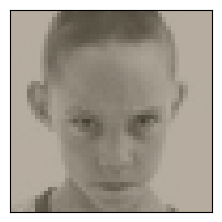

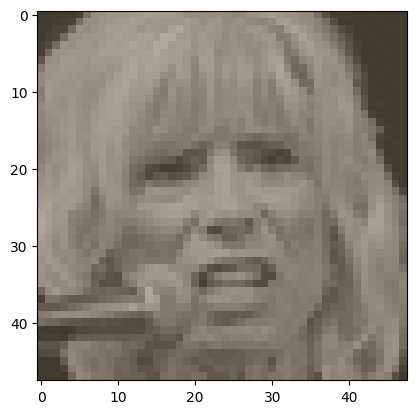

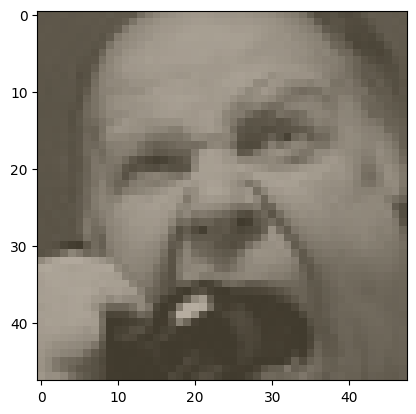

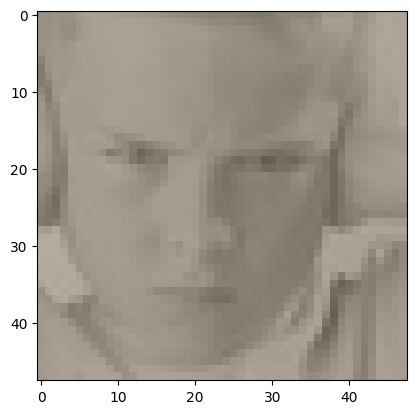

<Figure size 640x480 with 0 Axes>

In [9]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.cpu().numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
images, labels = next(iter(test_loader))

# Make predictions
outputs = model(images.to(device))
_, preds = torch.max(outputs, 1)

# Original emotion labels for FER2013
emotion_labels = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']

# Display images with predicted and true labels
fig = plt.figure(figsize=(12, 6))
for i in range(min(4, len(images))):  # Limit to 4 or the batch size
    ax = fig.add_subplot(1, 4, i + 1, xticks=[], yticks=[])
    imshow(images[i])
    # Assuming 'labels' and 'preds' are indices 0-6 for FER2013 emotions
    true_label = emotion_labels[labels[i]]
    pred_label = emotion_labels[preds[i]]
    ax.set_title(f"True: {true_label}\nPred: {pred_label}")

plt.tight_layout()
plt.show()